In [1]:
import efficientnet.tfkeras as efn

In [9]:
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split 
import tensorflow as tf
from tensorflow.keras import Model, backend
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
from keras.utils.vis_utils import plot_model

import pydicom
import cv2

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

palette_ro = ["#ee2f35", "#fa7211", "#fbd600", "#75c731", "#1fb86e", "#0488cf", "#7b44ab"]

ROOT = "../Efficient_Net/"

In [10]:
train = pd.read_csv(ROOT + "train.csv")
test = pd.read_csv(ROOT + "test.csv")
sub = pd.read_csv(ROOT + "sample_submission.csv")

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)

train.head(10)

Training data shape:  (1549, 7)
Test data shape:  (5, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker


In [15]:
train.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [16]:
test.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [17]:
dupRows_train = train[train.duplicated(subset=['Patient', 'Weeks'], keep=False)]

print("There are {} duplicate rows here ({:.2f} percent of the total).".format(len(dupRows_train), len(dupRows_train)/len(train)*100))
dupRows_train

There are 14 duplicate rows here (0.90 percent of the total).


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
166,ID00048637202185016727717,9,1375,60.059404,70,Female,Never smoked
167,ID00048637202185016727717,9,1477,64.514720,70,Female,Never smoked
226,ID00068637202190879923934,11,2794,82.633385,73,Male,Ex-smoker
227,ID00068637202190879923934,11,2827,83.609369,73,Male,Ex-smoker
306,ID00089637202204675567570,7,2478,57.967624,63,Male,Never smoked
307,ID00089637202204675567570,7,2539,59.394592,63,Male,Never smoked
465,ID00125637202218590429387,8,2349,53.757781,65,Male,Never smoked
466,ID00125637202218590429387,8,2584,59.135848,65,Male,Never smoked
750,ID00199637202248141386743,5,2672,64.728682,62,Male,Ex-smoker
751,ID00199637202248141386743,5,2683,64.995155,62,Male,Ex-smoker


In [18]:
train.drop_duplicates(subset=['Patient', 'Weeks'], keep=False, inplace=True)

In [19]:
stats = []
for col in train.columns:
    stats.append((col,
                  train[col].nunique(),
                  train[col].value_counts().index[0],
                  train[col].value_counts().values[0],
                  train[col].isnull().sum() * 100 / train.shape[0],
                  train[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  train[col].dtype))
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique values', 'Most frequent item', 'Freuquence of most frequent item', 'Percentage of missing values', 'Percentage of values in the biggest category', 'Type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique values,Most frequent item,Freuquence of most frequent item,Percentage of missing values,Percentage of values in the biggest category,Type
0,Patient,176,ID00140637202231728595149,10,0.0,0.651466,object
1,Weeks,112,12,44,0.0,2.866450,int64
2,FVC,1193,2965,4,0.0,0.260586,int64
3,Percent,1522,91.578893,2,0.0,0.130293,float64
4,Age,34,65,131,0.0,8.534202,int64
5,Sex,2,Male,1212,0.0,78.957655,object
6,SmokingStatus,3,Ex-smoker,1030,0.0,67.100977,object


In [26]:
data = train.groupby("Patient").first()
data

,Weeks,FVC,Percent,Age,Sex,SmokingStatus
Patient,,,,,,
ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker
ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker
ID00011637202177653955184,6,3326,85.987590,72,Male,Ex-smoker
ID00012637202177665765362,33,3418,93.726006,65,Male,Never smoked
...,...,...,...,...,...,...
ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker


C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

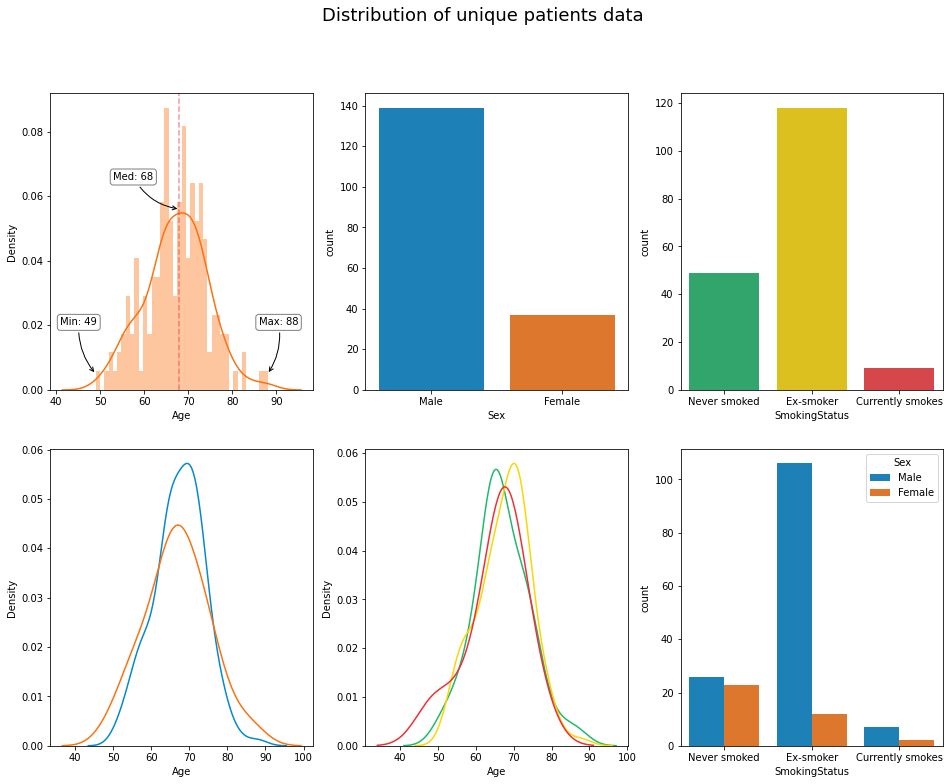

In [27]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 12))
#fig a
sns.distplot(data["Age"], ax=ax1, bins=data["Age"].max()-data["Age"].min()+1, color=palette_ro[1])
ax1.annotate("Min: {:,}".format(data["Age"].min()), xy=(data["Age"].min(), 0.005), 
             xytext=(data["Age"].min()-8, 0.02),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=0.2"))
ax1.annotate("Max: {:,}".format(data["Age"].max()), xy=(data["Age"].max(), 0.005), 
             xytext=(data["Age"].max()-2, 0.02),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=-0.2"))
ax1.axvline(x=data["Age"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax1.annotate("Med: {:.0f}".format(data["Age"].median()), xy=(data["Age"].median(), 0.056), 
             xytext=(data["Age"].median()-15, 0.065),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=0.25"))
#fig f
sns.countplot(x="Sex", ax=ax2, data=data, palette=palette_ro[-2::-4])
sns.countplot(x="SmokingStatus", ax=ax3, data=data,
              order=["Never smoked", "Ex-smoker", "Currently smokes"], palette=palette_ro[-3::-2])
#fig b
sns.distplot(data[data["Sex"]=="Male"].Age, label="Male", ax=ax4, hist=False, color=palette_ro[5])
sns.distplot(data[data["Sex"]=="Female"].Age, label="Female", ax=ax4, hist=False, color=palette_ro[1])
#fig c
sns.distplot(data[data["SmokingStatus"]=="Never smoked"].Age, label="Never smoked", ax=ax5, hist=False, color=palette_ro[4])
sns.distplot(data[data["SmokingStatus"]=="Ex-smoker"].Age, label="Ex-smoker", ax=ax5, hist=False, color=palette_ro[2])
sns.distplot(data[data["SmokingStatus"]=="Currently smokes"].Age, label="Currently smokes", ax=ax5, hist=False, color=palette_ro[0])

sns.countplot(x="SmokingStatus", ax=ax6, data=data, hue="Sex",
              order=["Never smoked", "Ex-smoker", "Currently smokes"], palette=palette_ro[-2::-4])

fig.suptitle("Distribution of unique patients data", fontsize=18);

C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


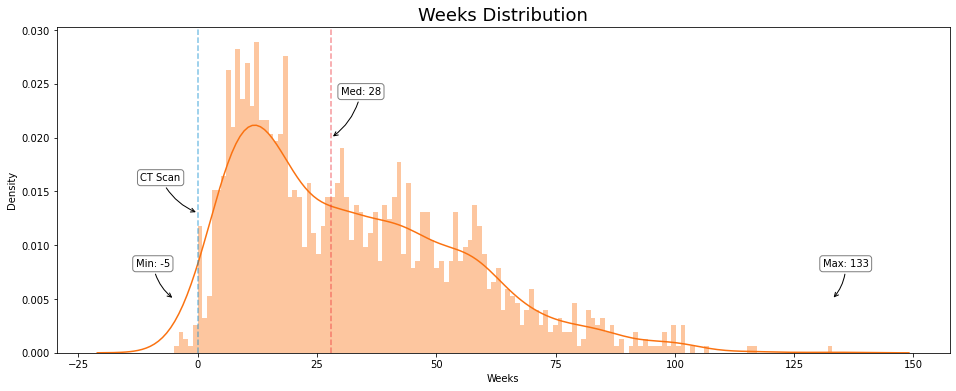

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.distplot(train["Weeks"], ax=ax, color=palette_ro[1], bins=train["Weeks"].max()-train["Weeks"].min()+1)
ax.annotate("Min: {:,}".format(train["Weeks"].min()), xy=(train["Weeks"].min(), 0.005), 
            xytext=(train["Weeks"].min()-8, 0.008),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))
ax.annotate("Max: {:,}".format(train["Weeks"].max()), xy=(train["Weeks"].max(), 0.005), 
            xytext=(train["Weeks"].max()-2, 0.008),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=-0.2"))
ax.axvline(x=0, color=palette_ro[5], linestyle="--", alpha=0.5)
ax.annotate("CT Scan", xy=(0, 0.013), 
            xytext=(-12, 0.016),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))
ax.axvline(x=train["Weeks"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax.annotate("Med: {:.0f}".format(train["Weeks"].median()), xy=(train["Weeks"].median(), 0.020), 
            xytext=(train["Weeks"].median()+2, 0.024),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))

ax.set_title("Weeks Distribution", fontsize=18);

C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


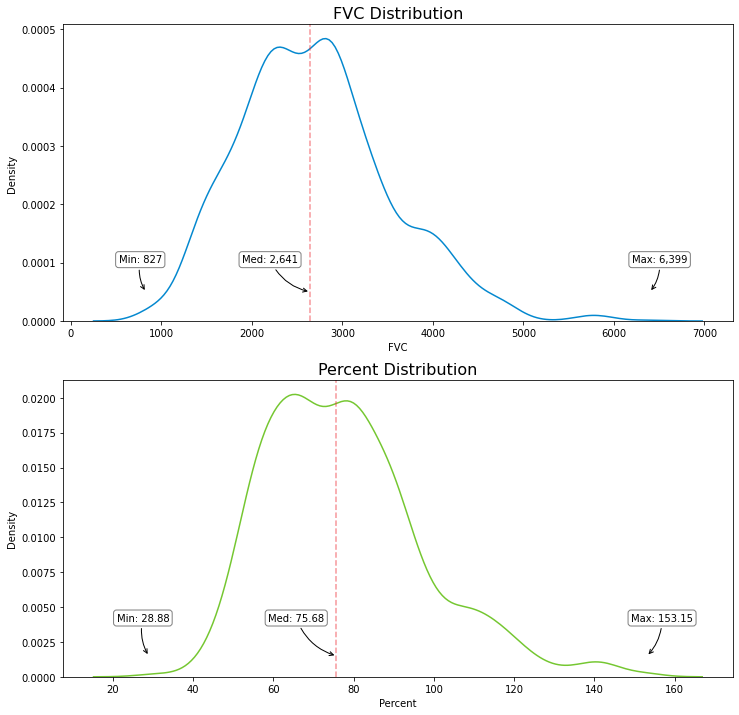

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.distplot(train["FVC"], ax=ax1, color=palette_ro[5], hist=False)
ax1.annotate("Min: {:,}".format(train["FVC"].min()), xy=(train["FVC"].min(), 0.00005), 
             xytext=(train["FVC"].min()-300, 0.0001),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))
ax1.annotate("Max: {:,}".format(train["FVC"].max()), xy=(train["FVC"].max(), 0.00005), 
             xytext=(train["FVC"].max()-200, 0.0001),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=-0.2"))
ax1.axvline(x=train["FVC"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax1.annotate("Med: {:,.0f}".format(train["FVC"].median()), xy=(train["FVC"].median(), 0.00005), 
             xytext=(train["FVC"].median()-750, 0.0001),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

ax1.set_title("FVC Distribution", fontsize=16);

sns.distplot(train["Percent"], ax=ax2, color=palette_ro[3], hist=False)
ax2.annotate("Min: {:.2f}".format(train["Percent"].min()), xy=(train["Percent"].min(), 0.0015), 
             xytext=(train["Percent"].min()-8, 0.0040),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))
ax2.annotate("Max: {:.2f}".format(train["Percent"].max()), xy=(train["Percent"].max(), 0.0015), 
             xytext=(train["Percent"].max()-4, 0.0040),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=-0.2"))
ax2.axvline(x=train["Percent"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax2.annotate("Med: {:.2f}".format(train["Percent"].median()), xy=(train["Percent"].median(), 0.0015), 
             xytext=(train["Percent"].median()-17, 0.0040),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

ax2.set_title("Percent Distribution", fontsize=16);


C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PrEdAtOr\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

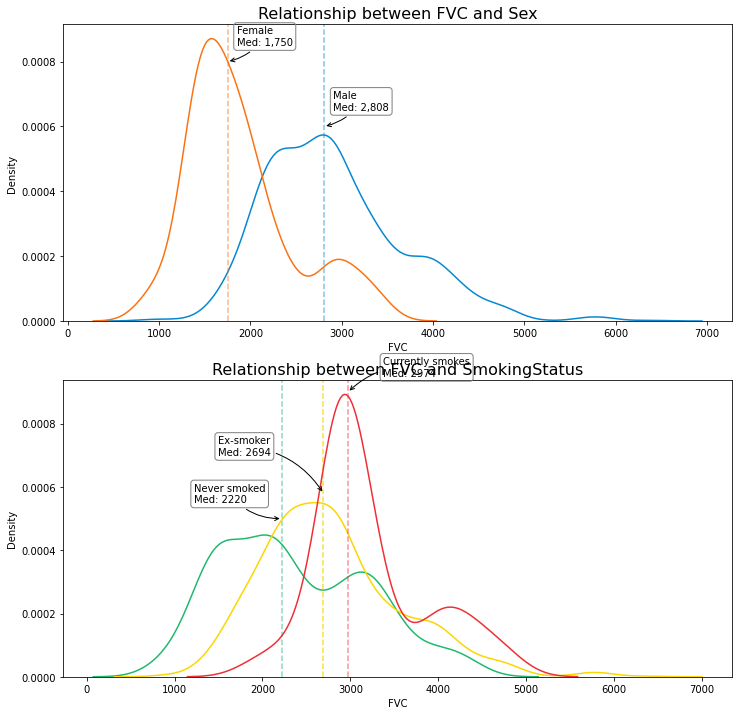

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.distplot(train[train["Sex"]=="Male"].FVC, label="Male", ax=ax1, hist=False, color=palette_ro[5])
ax1.axvline(x=train[train["Sex"]=="Male"].FVC.median(), color=palette_ro[5], linestyle="--", alpha=0.5)
ax1.annotate("Male\nMed: {:,.0f}".format(train[train["Sex"]=="Male"].FVC.median()), xy=(train[train["Sex"]=="Male"].FVC.median(), 0.0006), 
             xytext=(train[train["Sex"]=="Male"].FVC.median()+100, 0.00065),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))
sns.distplot(train[train["Sex"]=="Female"].FVC, label="Female", ax=ax1, hist=False, color=palette_ro[1])
ax1.axvline(x=train[train["Sex"]=="Female"].FVC.median(), color=palette_ro[1], linestyle="--", alpha=0.5)
ax1.annotate("Female\nMed: {:,.0f}".format(train[train["Sex"]=="Female"].FVC.median()), xy=(train[train["Sex"]=="Female"].FVC.median(), 0.0008), 
             xytext=(train[train["Sex"]=="Female"].FVC.median()+100, 0.00085),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))

sns.distplot(train[train["SmokingStatus"]=="Never smoked"].FVC, label="Never smoked", ax=ax2, hist=False, color=palette_ro[4])
ax2.axvline(x=train[train["SmokingStatus"]=="Never smoked"].FVC.median(), color=palette_ro[4], linestyle="--", alpha=0.5)
ax2.annotate("Never smoked\nMed: {:.0f}".format(train[train["SmokingStatus"]=="Never smoked"].FVC.median()), xy=(train[train["SmokingStatus"]=="Never smoked"].FVC.median(), 0.0005), 
             xytext=(train[train["SmokingStatus"]=="Never smoked"].FVC.median()-1000, 0.00055),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))
sns.distplot(train[train["SmokingStatus"]=="Ex-smoker"].FVC, label="Ex-smoker", ax=ax2, hist=False, color=palette_ro[2])
ax2.axvline(x=train[train["SmokingStatus"]=="Ex-smoker"].FVC.median(), color=palette_ro[2], linestyle="--", alpha=0.75)
ax2.annotate("Ex-smoker\nMed: {:.0f}".format(train[train["SmokingStatus"]=="Ex-smoker"].FVC.median()), xy=(train[train["SmokingStatus"]=="Ex-smoker"].FVC.median(), 0.00058), 
             xytext=(train[train["SmokingStatus"]=="Ex-smoker"].FVC.median()-1200, 0.0007),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.25"))
sns.distplot(train[train["SmokingStatus"]=="Currently smokes"].FVC, label="Currently smokes", ax=ax2, hist=False, color=palette_ro[0])
ax2.axvline(x=train[train["SmokingStatus"]=="Currently smokes"].FVC.median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax2.annotate("Currently smokes\nMed: {:.0f}".format(train[train["SmokingStatus"]=="Currently smokes"].FVC.median()), xy=(train[train["SmokingStatus"]=="Currently smokes"].FVC.median(), 0.0009), 
             xytext=(train[train["SmokingStatus"]=="Currently smokes"].FVC.median()+400, 0.00095),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

ax1.set_title("Relationship between FVC and Sex", fontsize=16)
ax2.set_title("Relationship between FVC and SmokingStatus", fontsize=16);